<h1 align='center'>Итоговая работа</h1>

### Реализация логистической регрессии с регуляризацией и использованием градиентного спуска
<hr>

**Цель:** 
отработать технику разработки модулей(PyCharm) для их использования в jupyter notebook

**Проведенные работы**
- подготовлен класс RegLogReg с интерфесом fit, predict, predict_proba
  - разработка класса проведена с использованием ABC
  - класс снабжен дополнительным методом для визуализации (экспорт в png)
  - основные параметры могут быть настроены, для удобства использования проставлены дефолтные значения
- созданный класс протестирован в рамках отдельного py-модуля:
  - файл [check_wo_notebook.py](check_wo_notebook.py)
  - итерационный процесс логирован [logreg.py.log](logs%2Flogreg.py.log)
  - создана и сохранена иллюстрация ![RegLogReg_01_X_train.png](assets%2FRegLogReg_01_X_train.png)
- созданный класс применен в jupyter notebook, где проведены следующие работы:
  - простой EDA масcива данных bankloan.csv
  - базовая доработка данных
  - реализовано моделирование на основе разработанного класса
  - результат сравнен с базовым алгоритмом

## 0. Инициализация

In [1]:
import pandas as pd
print(f'pandas: {pd.__version__}')
import numpy as np
print(f'numpy: {np.__version__}')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.display import HTML, display
import tqdm

# !pip install imbalanced-learn
import imblearn
print(f'imblearn: {imblearn.__version__}')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pandas: 2.2.1
numpy: 1.26.4
imblearn: 0.12.0


## 1. Загрузка данных и краткий обзор
IMDB_Dataset.zip - отзывы о фильмах.
<br>train.csv        - отзывы о еде с сайта Амазон.
<br>bankloan.csv     - краткая информация о заемщике и решение о выдаче кредита.

После загрузки данные приводятся к единообразной структуре.

In [2]:
%%time

strFileName1='data/IMDB_Dataset.zip'
df1 = pd.read_csv(strFileName1, compression='zip')
df1.name='IMDB Film Review'
df1.rename(columns={'sentiment': 'target'}, inplace=True)
df1['target'] = df1['target'].map({'positive': 1, 'negative': 0})

strFileName2='data/train.csv'
df2= pd.read_csv(strFileName2, sep=',')
df2.name='Amazone Food Review'
df2.rename(columns={'Prediction': 'target','Reviews_Summary': 'review'}, inplace=True)

strFileName3='data/bankloan.csv'
df3= pd.read_csv(strFileName3, sep=';', decimal=',')
df3.name='Bank Loan'
df3.rename(columns={'default': 'target'}, inplace=True)

for d in [df1, df2, df3]:
    d['target'] = d['target'].astype('int')
    display(HTML(f'<br><br>{d.name}<hr>'))
    print(f'Data shape: {d.shape}\n')
    print(d.info(),'\n')
    chosen_idx = np.random.choice(d.shape[0], replace=False, size=5)
    display(d.iloc[chosen_idx])    
    print('\nBalance')
    display(d.target.value_counts(normalize=True))


Data shape: (50000, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   target  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None 



,review,target
12492,This film is likely to be a real letdown unles...,0
28014,"Hello all--for what it's worth, I'm in a docto...",0
41771,Note: I couldn't force myself to actually writ...,0
14374,"As I am no fan of almost any post-""Desperate L...",1
23190,"Ned Kelly (Ledger), the infamous Australian ou...",0



Balance


target
1    0.5
0    0.5
Name: proportion, dtype: float64

Data shape: (110163, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110163 entries, 0 to 110162
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      110163 non-null  int64 
 1   review  110163 non-null  object
 2   target  110163 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ MB
None 



,ID,review,target
63305,521897,No Information,0
71944,184046,Old chocolate,0
41088,226192,Gloria Jean's Hazelnut K-cups,1
13554,481868,Love them,1
77278,311040,One note - bitter,0



Balance


target
0    0.50074
1    0.49926
Name: proportion, dtype: float64

Data shape: (1500, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1500 non-null   int64  
 1   job       1500 non-null   object 
 2   debtinc   1500 non-null   float64
 3   creddebt  1500 non-null   float64
 4   othdebt   1500 non-null   float64
 5   target    1500 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 70.4+ KB
None 



,age,job,debtinc,creddebt,othdebt,target
773,34,own business,9.4,0.076704,2.179296,1
527,28,own business,6.2,0.572880,0.667120,0
832,40,working - other,36.6,4.350276,3.335724,1
542,39,working - production,7.0,10.450650,2.499350,1
476,22,working - other,9.8,0.312032,1.255968,1



Balance


target
0    0.634667
1    0.365333
Name: proportion, dtype: float64

CPU times: user 514 ms, sys: 70.2 ms, total: 584 ms
Wall time: 610 ms


---

Два первых набора данных хорошо сбалансированы относительно цели.
<br>Третий - требует дополнительной балансировки (SMOTE).
<br>Пропусков в данных нет. После доработки третьего набора данных, можем оценивать качество модели по метрике ```accuracy```.


---
## 2.1 Работа с первыми двумя наборами данных. Отзывы -> вектор
Для решения задачи классификации необходимо преобразовать ```review``` в частотные векторы слова с помощью <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html'>TfidfVectorizer</a>

```feature_extraction.text.TfidfVectorizer(*[, ...])``` Convert a collection of raw documents to a matrix of TF-IDF features.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
%%time

# d=df1
# display(HTML(f'<br>{d.name}<hr>'))
# review_summaries=d['review'].map(str.lower).tolist()
# review_summaries[:5]

# vectorizer1 = TfidfVectorizer()
# X1 = vectorizer1.fit_transform(review_summaries)
# display(vectorizer1.get_feature_names_out()[10024:10030])
# print(f'X1.shape: {X1.shape}\n')

d=df2
display(HTML(f'<br>{d.name}<hr>'))
review_summaries=d['review'].map(str.lower).tolist()
review_summaries[:5]

vectorizer2 = TfidfVectorizer()
X2 = vectorizer2.fit_transform(review_summaries)
display(vectorizer2.get_feature_names_out()[10024:10030])
print(f'X2.shape: {X2.shape}\n')

array(['oooooooooo', 'ooops', 'oops', 'oothu', 'oozing', 'opal'],
      dtype=object)

X2.shape: (110163, 16230)

CPU times: user 296 ms, sys: 2.86 ms, total: 299 ms
Wall time: 308 ms


---
## 2.2 Доработка 3-его набора данных

1. Дополним набор данными для балансировки целевого показателя
2. Стандартизируем данные

## 3. Логистическая регрессия

In [5]:
from sklearn.model_selection import train_test_split

In [8]:
y = df2.target.values
X_train, X_test, y_train, y_test = train_test_split(X2, y, train_size=0.7, random_state=202402)

In [9]:
from utils import grad_check_sparse
from dmia.classifiers import LogisticRegression
from dmia.candidate03 import RegLogReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'dmia'

## Gradient check

Реализован подход, найденный в [CS231n](https://github.com/lightaime/cs231n/blob/master/assignment1/cs231n/gradient_check.py)

In [10]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: (0.0,) analytic: 0.0, relative error: nan
numerical: (0.0,) analytic: 0.0, relative error: nan
numerical: (-5.093447885684554e-05,) analytic: -5.093449062027394e-05, relative error: 1.1547607147125563e-07
numerical: (4.036038170340817e-06,) analytic: 4.036024840455811e-06, relative error: 1.6513603756552422e-06
numerical: (0.0,) analytic: 0.0, relative error: nan
numerical: (0.0,) analytic: 0.0, relative error: nan
numerical: (-6.132637730971169e-05,) analytic: -6.132638129535532e-05, relative error: 3.2495344374630197e-08
numerical: (1.7146639663678798e-05,) analytic: 1.714664477821504e-05, relative error: 1.4914104396669596e-07
numerical: (-0.00016822240267444497,) analytic: -0.00016822240624844807, relative error: 1.0622851073869818e-08
numerical: (0.0,) analytic: 0.0, relative error: nan


/home/etkin_a/PycharmProjects/MLBasic202308/dmia/utils.py:40: RuntimeWarning: invalid value encountered in scalar divide
  rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))


In [22]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = RegLogReg()

clf.beta = np.random.randn(X_train_sample.shape[1]+1) * 2
clf._initialize_weights(X_train_sample.shape[1])
loss, grad = clf._calculate_loss(X_train_sample, y_train_sample)

print(loss, grad)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
# f = lambda w: clf.logregloss(RegLogReg.append_biases(X_train_sample), y_train_sample, 0.0)
# grad_numerical = grad_check_sparse(f, clf.beta, grad, 10)

TypeError: loop of ufunc does not support argument 0 of type csr_matrix which has no callable exp method

In [12]:
loss

1.236654666756952

Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [13]:
# clf = LogisticRegression()
clf = RegLogReg()

In [14]:
model = RegLogReg()
model.fit(X_train, y_train)
proba = model.predict_proba(X_test)
result = np.round(roc_auc_score(y_test, proba), 3)
model.loss_visualize(strFileName + '_X_train', result)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 77114 and the array at index 1 has size 1

In [67]:
clf.fit(X_train, y_train)
print("Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 77114 and the array at index 1 has size 1

Нарисуем кривые обучения.

In [136]:
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in tqdm.trange(num_iters):
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

100%|███████████████████████████████████████| 1000/1000 [06:15<00:00,  2.66it/s]


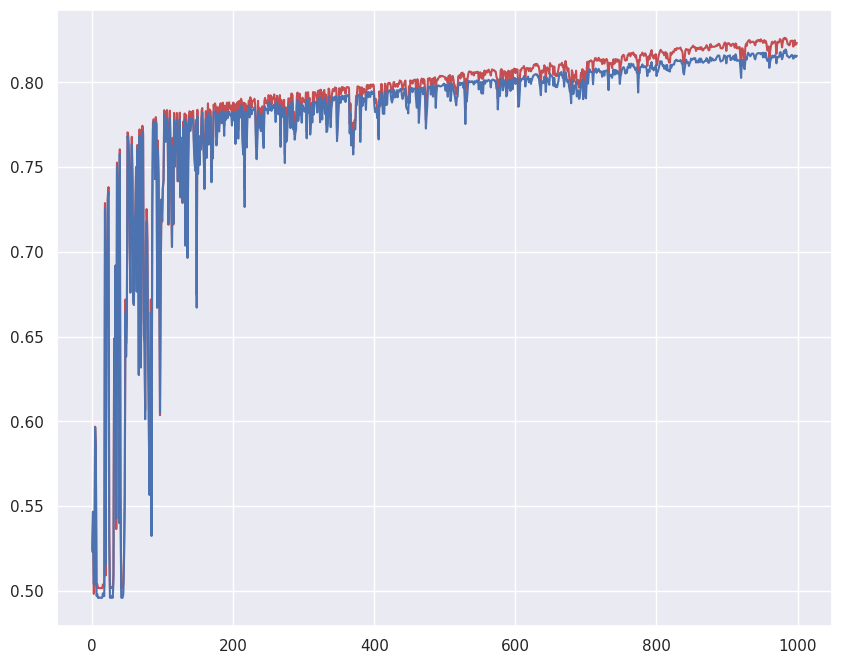

In [137]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучим нашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведем первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедимся, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 

**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [17]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

iteration 0 / 1000: loss 0.693145
iteration 100 / 1000: loss 0.619765
iteration 200 / 1000: loss 0.581789
iteration 300 / 1000: loss 0.543190
iteration 400 / 1000: loss 0.489438
iteration 500 / 1000: loss 0.474889
iteration 600 / 1000: loss 0.464601
iteration 700 / 1000: loss 0.472835
iteration 800 / 1000: loss 0.453326
iteration 900 / 1000: loss 0.429012


In [18]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-5:]
neg_features = np.argsort(clf.w)[:5]

In [19]:
# Выведите слова
fnames = vectorizer.get_feature_names_out()
print([fnames[p] for p in pos_features])
print([fnames[n] for n in neg_features])

['excellent', 'delicious', 'love', 'best', 'great']
['not', 'disappointed', 'bad', 'too', 'but']


## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [20]:
from sklearn import linear_model

In [21]:
clf = linear_model.SGDClassifier(max_iter=1000, random_state=42, loss="log_loss", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="constant")
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, eta0=1.0, learning_rate='constant', loss='log_loss',
              random_state=42)

In [22]:
print("Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test)))

Train accuracy = 0.809
Test accuracy = 0.805
